#4. Градиентный бустинг

Задание:

Внимание: два варианта работы

Построить модель для распознавания целевой переменной (отклика)

Использовать тот же набор данных, что и в первой лабораторной работе.

Для распознавания использовать Градиентный бустинг

Выбор критерия качества на Ваше усмотрение.

Обосновать выбор параметров модели.

Ожидается, что для подбора значений параметров будет использован GridSearch. Возможен выбор других стратегий подбора.




Ответ:

В данном задании была построена модель для распознавания целевой переменной (отклика) на основе Bank Marketing Data Set. Для распознавания использовался градиентный бустинг. Критерием качества для данной выборки выбран Recall.

In [186]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [187]:
df = pd.read_csv('bank-full.csv', delimiter=';')

In [188]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [189]:
df.shape

(45211, 17)

In [190]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [191]:
# Атрибут 'duration' сильно влияет на цель вывода (например, если duration=0, то y='no'),
# поэтому эти данные отбрасываем для получения реалистичной прогностической модели

df = df.loc[df['duration'] != 0]
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [192]:
df.shape

(45208, 17)

In [193]:
# Проверим сбалансированность выборки

df['y'].value_counts() # выборка не сбалансированная, тк разница в 8 раз

no     39919
yes     5289
Name: y, dtype: int64

In [194]:
df['y'].value_counts(normalize=True) # выборка не сбалансированная, тк разница в 8 раз

no     0.883007
yes    0.116993
Name: y, dtype: float64

In [195]:
# Получим новый датафрейм только со значением y=yes

df_one = df.loc[df['y'] == 'yes']
df_one.shape

(5289, 17)

In [196]:
# Получим новый датафрейм только со значением y=no и обновим индексы

df_y = df.loc[df['y'] == 'no']
df_y = df_y.reset_index(drop=True)
df_y.shape

(39919, 17)

In [197]:
# Отделим первые 10578 строк значений в датафрейме только со значением y=no

df_two = df_y.loc[:10577]
df_two.shape

(10578, 17)

In [198]:
# Создадим новый датафрейм, состоящий из двойного набора данных со значением отклика y=yes (5289*2=10578 строк)
# и набора данных со значением отклика y=no (10578 строк)

df_new = pd.concat([df_one, df_one, df_two], ignore_index=True)
df_new.shape

(21156, 17)

In [199]:
# Проверим сбалансированность выборки нового датафрейма

df_new['y'].value_counts() # выборка сбалансирована

yes    10578
no     10578
Name: y, dtype: int64

In [200]:
df_new['y'].value_counts(normalize=True) # выборка сбалансирована

yes    0.5
no     0.5
Name: y, dtype: float64

{0: 'admin.', 1: 'blue-collar', 2: 'entrepreneur', 3: 'housemaid', 4: 'management', 5: 'retired', 6: 'self-employed', 7: 'services', 8: 'student', 9: 'technician', 10: 'unemployed', 11: 'unknown'}


Text(0.5, 1.0, 'Распределение частотности классов в атрибуте job')

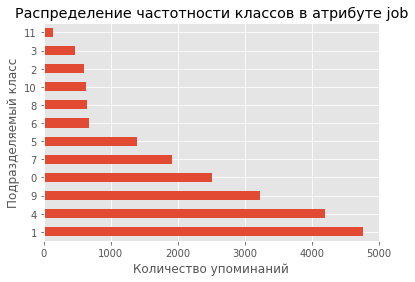

In [201]:
# Заменим категориальные признаки на числовые во всем датафрейме

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
mapped_job = pd.Series(label_encoder.fit_transform(df_new['job']))

mapped_job.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

plt.xlabel('Количество упоминаний')
plt.ylabel('Подразделяемый класс')
plt.title('Распределение частотности классов в атрибуте job')

In [202]:
categorical_columns = df_new.columns[df_new.dtypes == 'object'].union(['job'])
for column in categorical_columns:
    df_new[column] = label_encoder.fit_transform(df_new[column])
df_new.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,59,0,1,1,0,2343,1,0,2,5,8,1042,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,5,8,1467,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,5,8,1389,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,3,1


In [203]:
df_new.shape

(21156, 17)

In [204]:
# Преобразуем в столбцы с различными уникальными значениями, которые могут принимать категориальные столбцы исходной выборки

onehot_encoder = OneHotEncoder(sparse=False)

encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(df_new[categorical_columns]))
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [205]:
#  Разделим предикторы и отклики

X = df_new.iloc[:, :-1]
y = df_new.iloc[:, 16]

In [206]:
# Разделими на обучающую и тестовую выборки

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 1234)  

In [207]:
# Подбор внешних параметров с помощью GridSearchCV
# Применение GradientBoostingClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

model = GradientBoostingClassifier(random_state=42,                                  
                                   subsample=0.66,                                  
                                   max_features='sqrt',                                 
                                   n_estimators=500,              # Число деревьев                  
                                   loss='deviance',               # критерий качества ‘deviance’ (кросс-энтропия) или ‘exponential’ (как в AdaBoost)  #  ‘deviance’ для классификации с вероятностями на выходе  
                                   learning_rate=0.01,            # параметр, который умножаем на лямбда                               
                                   criterion='friedman_mse',      # загрязнение дерева измеряем “friedman_mse”  (mse с улучшениями)                                 
                                   min_impurity_decrease=0.001,   # минимальное уменьшение загрязнения                             
                                   min_samples_leaf=5,                                 
                                   min_samples_split=10,                                 
                                   max_depth=5,                             
                                   verbose=0)                      # насколько подробны должны быть промежуточные результаты                          

from sklearn.model_selection import GridSearchCV

param_grid = {  
    'n_estimators': [40, 60, 80, 100],
    'max_depth': [4, 6, 8],
    'max_features': [5, 10, 12],
    'min_samples_split': [5, 10, 12],
    'min_samples_leaf': [2, 4, 8],
  }

grid_search_res = GridSearchCV(model, param_grid=param_grid, cv=2,   # 2 фолда                        
                               scoring='recall',                     #  выбор критерия качества                
                               error_score='raise',                  #  поведение в случае ошибки при вычислении критерия качества                   
                               refit=True,                           #  обучить модель с лучшими значениями параметроы
                               pre_dispatch=None, 
                               verbose=0)

grid_search_res.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise',
             estimator=GradientBoostingClassifier(learning_rate=0.01,
                                                  max_depth=5,
                                                  max_features='sqrt',
                                                  min_impurity_decrease=0.001,
                                                  min_samples_leaf=5,
                                                  min_samples_split=10,
                                                  n_estimators=500,
                                                  random_state=42,
                                                  subsample=0.66),
             param_grid={'max_depth': [4, 6, 8], 'max_features': [5, 10, 12],
                         'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [5, 10, 12],
                         'n_estimators': [40, 60, 80, 100]},
             pre_dispatch=None, scoring='recall')

In [208]:
#   Лучший набор значений гиперпараметров

best_hyperparams = grid_search_res.best_params_
print('Лучшие значения гиперпараметров:\n', best_hyperparams)

#можно было бы посмотреть еще больше, тк кажется будто это не предел, не максимум значений

Лучшие значения гиперпараметров:
 {'max_depth': 8, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 80}


In [209]:
# Значение критерия качества для лучших значений гиперпараметров 

best_CV_score = grid_search_res.best_score_
print('Лучший recall', best_CV_score)

Лучший recall 0.9679469076532053


In [210]:
# Лучшая модель
best_model = grid_search_res.best_estimator_

# recall на тестовом множестве для лучшей модели
test_recall = best_model.score(X_test,y_test)

# Значение критерия качества для лучших значений гиперпараметров 
print('Лучший recall на тестовом множестве', test_recall)

Лучший recall на тестовом множестве 0.9727871670008593


In [211]:
grid_search_res.cv_results_

{'mean_fit_time': array([0.3821559 , 0.5806849 , 0.88751686, 0.95208073, 0.35989273,
        0.60304737, 1.14757717, 1.24842668, 0.39882278, 0.53402591,
        1.01355362, 1.33288729, 0.44314289, 0.5528084 , 0.91436088,
        1.07254803, 0.26121616, 0.3253777 , 0.44452512, 0.55954623,
        0.21449292, 0.32341409, 0.43916941, 0.54485703, 0.21680558,
        0.32706344, 0.44467521, 0.54344702, 0.22091627, 0.3211807 ,
        0.43028486, 0.54400635, 0.21341455, 0.33368909, 0.43066323,
        0.54676318, 0.27497935, 0.4198904 , 0.57334137, 0.72375894,
        0.27158344, 0.41930747, 0.55407131, 0.71535552, 0.27378857,
        0.41795528, 0.56197822, 0.70549214, 0.27992404, 0.41813302,
        0.56878424, 0.71519256, 0.27573121, 0.4192121 , 0.57770205,
        0.71177936, 0.27482212, 0.41548085, 0.56875229, 0.71151328,
        0.2808224 , 0.41828954, 0.55226755, 0.70235872, 0.28180039,
        0.4134258 , 0.54881263, 0.69476259, 0.27446449, 0.41431963,
        0.54494953, 0.68854308,

In [212]:
means = grid_search_res.cv_results_['mean_test_score']
stds  = grid_search_res.cv_results_['std_test_score']

In [213]:
for mean, std, params in zip(means, stds, grid_search_res.cv_results_['params']):
    print("%0.4f (+/-%0.03f) for %r"  % (mean, std * 2, params))
print()

# +- два стандартных отклонения

0.9126 (+/-0.005) for {'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 40}
0.9126 (+/-0.005) for {'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 60}
0.9127 (+/-0.005) for {'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 80}
0.9184 (+/-0.003) for {'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
0.9126 (+/-0.005) for {'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 40}
0.9126 (+/-0.005) for {'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 60}
0.9127 (+/-0.005) for {'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 80}
0.9140 (+/-0.007) for {'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators':

In [214]:
# Строим предсказание модели

y_pred_train = grid_search_res.predict(X_train)
y_pred_test = grid_search_res.predict(X_test)

In [215]:
# Посчитаем precision, recall и f1-score

print(metrics.classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      7092
           1       0.99      0.97      0.98      7082

    accuracy                           0.98     14174
   macro avg       0.98      0.98      0.98     14174
weighted avg       0.98      0.98      0.98     14174



In [216]:
# Посчитаем precision, recall и f1-score

print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3486
           1       0.98      0.97      0.97      3496

    accuracy                           0.97      6982
   macro avg       0.97      0.97      0.97      6982
weighted avg       0.97      0.97      0.97      6982



In [217]:
# Таблица сопряженности. Обучающее множество

print(u'Таблица сопряженности для обучающей выборки')

conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=grid_search_res.classes_, columns=grid_search_res.classes_)
conf_mat

Таблица сопряженности для обучающей выборки


,0,1
0,6993,99
1,178,6904


In [218]:
# Таблица сопряженности. Тестовое множество

print(u'Таблица сопряженности для тестовой выборки')

conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=grid_search_res.classes_, columns=grid_search_res.classes_)
conf_mat

Таблица сопряженности для тестовой выборки


,0,1
0,3416,70
1,120,3376


In [219]:
print('Recall на обучающем множестве ', metrics.recall_score(y_train, y_pred_train)*100)
print('Recall на тестовом множестве ', metrics.recall_score(y_test, y_pred_test)*100)

Recall на обучающем множестве  97.48658571025133
Recall на тестовом множестве  96.5675057208238


In [220]:
# Посмотрим на важность признаков

model.fit(X_train, y_train)
fi = pd.DataFrame({'features': X_train.columns, 'importance': model.feature_importances_})
fi.sort_values('importance', ascending=False).head(16)

,features,importance
8,contact,0.504361
10,month,0.181354
11,duration,0.118080
14,previous,0.066410
13,pdays,0.045646
6,housing,0.027394
15,poutcome,0.025489
0,age,0.012304
9,day,0.005298
1,job,0.003692
